<a href="https://colab.research.google.com/github/AbderBouni/Satellite-Image-Deep-learning-using-U-net/blob/main/Satellite_Image_Deep_Learning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I:Introduction

This notebook provide a better understanding of satellite image analysis using two datasets . The model perform various tasks including land cover classification and Semantic segmentation,essential for applications in remote sensing, environmental monitoring, and urban planning.

#  Part II : Satellite Image Classification


In [ ]:
#Import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
#Import Data
import os
for dirname, _, filenames in os.walk(':/Users/Hp/Desktop/TNI Project/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#Download Images from folder
path="C:/Users/Hp/Desktop/TNI Project/data/All"
img_types= os.listdir('C:/Users/Hp/Desktop/TNI Project/data/dataset')
#combining all the images into a single folder
images=[]
for item in img_types:
    all_imgs= os.listdir('C:/Users/Hp/Desktop/TNI Project/data/dataset'+ '/'+ item)

    for img in all_imgs:
        images.append((item, str('C:/Users/Hp/Desktop/TNI Project/data/dataset' + '/' +item)+ '/' + img))

images[1]

('cloudy',
 'C:/Users/Hp/Desktop/TNI Project/data/dataset/cloudy/train_10043.jpg')

In [ ]:
#Create data dataframe
df= pd.DataFrame(data= images, columns=['img_type', 'image'])
#length of dataset
print(len(df))
print(df['img_type'].value_counts())
df.head()

5631
img_type
cloudy        1500
green_area    1500
water         1500
desert        1131
Name: count, dtype: int64


,img_type,image
0,cloudy,C:/Users/Hp/Desktop/TNI Project/data/dataset/c...
1,cloudy,C:/Users/Hp/Desktop/TNI Project/data/dataset/c...
2,cloudy,C:/Users/Hp/Desktop/TNI Project/data/dataset/c...
3,cloudy,C:/Users/Hp/Desktop/TNI Project/data/dataset/c...
4,cloudy,C:/Users/Hp/Desktop/TNI Project/data/dataset/c...


In [ ]:
output_path=('C:/Users/Hp/Desktop/TNI Project/data/data_out')
print(img_types)
print('types of images found: ', len(img_types))

['cloudy', 'desert', 'green_area', 'water']
types of images found:  4


# 1:Preprocessing

In [ ]:
import cv2

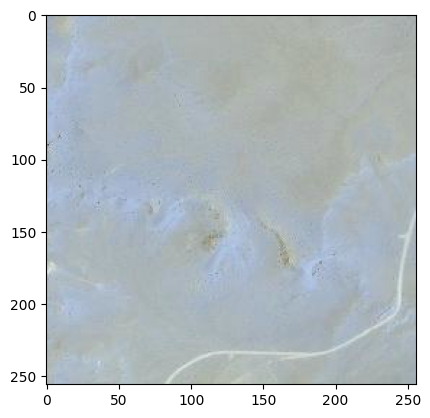

In [ ]:
im_path='C:/Users/Hp/Desktop/TNI Project/data/All'
img_org= cv2.imread(os.path.join(im_path, "desert(69).jpg"))
plt.imshow(img_org)

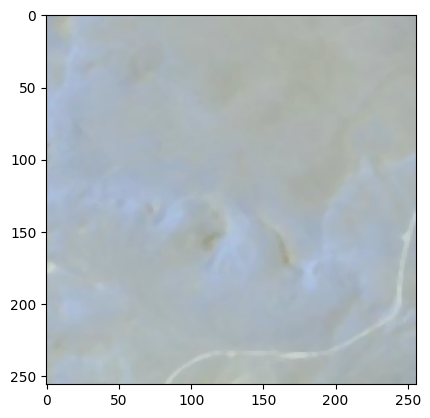

In [ ]:
#Le flou médian est particulièrement efficace pour éliminer le bruit impulsionnel (poivre et sel)
# sans flouter excessivement les bords des objets dans l'image.
#Vs blur gaussien = pas de preservation de contour
img_blurred = cv2.medianBlur(img_org, 5) #where 5 is filter size.
plt.imshow(img_blurred)

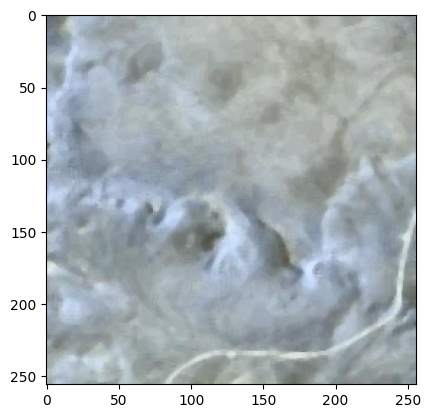

In [ ]:
#Convertion vers lab
lab = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2LAB)
#Separer les infos de luminance et de chrominance
l, a, b = cv2.split(lab) #L (luminance), A (canal de chrominance verte à rouge), et B (canal de chrominance bleue à jaune).
#Apply Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
#CLAHE améliore le contraste dans des régions locales de l'image,
#ce qui permet de mettre en évidence des détails dans des zones sombres ou claires.
l_eq = clahe.apply(l)
lab_eq = cv2.merge((l_eq, a, b))
img_or_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
plt.imshow(img_or_eq)

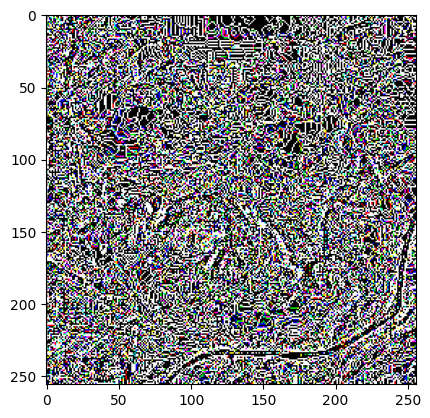

In [ ]:
#Détection des contour par la Dérivée Seconde (Laplacien)
laplacian = cv2.Laplacian(img_or_eq, cv2.CV_64F)
plt.imshow(laplacian)

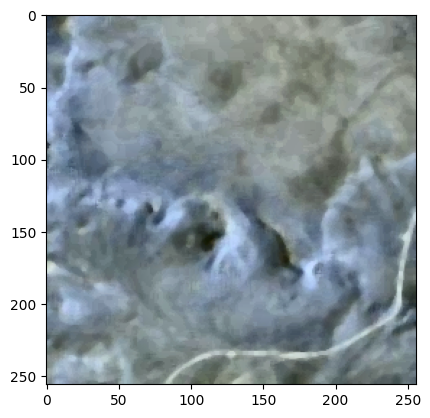

In [ ]:
#Contrast Stretching
min_val = np.min(img_or_eq)
max_val = np.max(img_or_eq)
img_stretched = (img_or_eq - min_val) * 255.0 / (max_val - min_val) ## Scale the pixel values to the full dynamic range of the image
img_stretched = np.uint8(img_stretched)
plt.imshow(img_stretched)

In [ ]:
#Effectue le process sur toutes les images
for filename in os.listdir(path):
  img = cv2.imread(os.path.join(path, filename))
  blurred = cv2.medianBlur(img, 5) #where 5 is filter size.

  lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  l_eq = clahe.apply(l)
  lab_eq = cv2.merge((l_eq, a, b))
  img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

  min_val = np.min(img_eq)
  max_val = np.max(img_eq)
  img_stretched = (img_eq - min_val) * 255.0 / (max_val - min_val) ## Scale the pixel values to the full dynamic range of the image
  img_stretched = np.uint8(img_stretched)

  #Saving The Preprocessed Images
  #cv2.imwrite(os.path.join(output_path, filename), img_stretched)

In [ ]:
#pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import splitfolders
splitfolders.ratio("C:/Users/Hp/Desktop/TNI Project/data/dataset", output = "C:/Users/Hp/Desktop/TNI Project/data/data_split2", seed=1337, move = False, ratio = (0.7,0.15,0.15), group_prefix=None)

Copying files: 5631 files [00:16, 340.94 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#preparation des données train,test and validation folders
#Data folders
train_dir="C:/Users/Hp/Desktop/TNI Project/data/data_split2/train"
validation_dir="C:/Users/Hp/Desktop/TNI Project/data/data_split2/val"
test_dir="C:/Users/Hp/Desktop/TNI Project/data/data_split2/test"
#Rescaling
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
training_set = train_datagen.flow_from_directory(train_dir, target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory(validation_dir, target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir, target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

Found 3941 images belonging to 4 classes.
Found 844 images belonging to 4 classes.
Found 846 images belonging to 4 classes.


# 2: Classification Deep Learning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

model = Sequential()
# Add the first convolutional layer
model.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add the second convolutional layer
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
# Add the third convolutional layer
model.add(Conv2D(192, (3, 3)))
model.add(Activation('relu'))
# Add the fourth convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the output from the convolutional layers
model.add(Flatten())
# Add the first fully connected layer
model.add(Dense(512))
model.add(Activation('relu'))
# Add the second fully connected layer
model.add(Dense(512))
model.add(Activation('relu'))
# Add the output layer
model.add(Dense(4))
model.add(Activation('softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitiing the Model
history = model.fit(x = training_set, validation_data = val_set, epochs = 5)

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.4975 - loss: 1.0098 - val_accuracy: 0.8223 - val_loss: 0.4354
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 120s 953ms/step - accuracy: 0.8072 - loss: 0.4440 - val_accuracy: 0.8246 - val_loss: 0.4856
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 120s 955ms/step - accuracy: 0.7977 - loss: 0.4637 - val_accuracy: 0.8318 - val_loss: 0.4148
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 124s 983ms/step - accuracy: 0.8466 - loss: 0.3640 - val_accuracy: 0.8329 - val_loss: 0.3815
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8412 - loss: 0.3802 - val_accuracy: 0.8140 - val_loss: 0.3830


In [ ]:
#Prints the accuracy of model, along with loss
evaluation_1 = model.evaluate(val_set)

#Predicts the Class of all the Images in Test Set and Saved in variable pred_classes
preds_probs = model.predict(test_set)
pred_classes = preds_probs.argmax(axis=1)
pred_classes

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8170 - loss: 0.3841


c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step


array([1, 3, 1, 1, 1, 0, 0, 3, 2, 1, 1, 3, 2, 2, 0, 0, 2, 3, 0, 3, 2, 1,
       3, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2, 1, 3, 3, 2, 2, 2, 2, 3, 2, 1,
       1, 2, 2, 1, 0, 2, 3, 0, 2, 2, 1, 1, 2, 1, 1, 2, 0, 2, 2, 1, 2, 3,
       3, 1, 0, 2, 2, 0, 1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 3, 2, 0, 3, 2, 1,
       1, 1, 2, 3, 2, 3, 2, 1, 0, 3, 0, 2, 1, 2, 2, 3, 0, 1, 0, 1, 2, 2,
       3, 1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 1, 2, 3, 0, 3, 0, 2, 2, 2, 1, 3,
       2, 2, 3, 1, 1, 2, 0, 2, 2, 0, 2, 3, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2,
       3, 1, 2, 2, 3, 3, 3, 1, 0, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2,
       2, 0, 1, 1, 1, 3, 1, 2, 2, 1, 1, 0, 3, 0, 1, 3, 1, 3, 2, 0, 0, 1,
       3, 3, 1, 1, 0, 0, 1, 0, 3, 0, 3, 1, 0, 0, 2, 1, 3, 0, 3, 2, 2, 3,
       2, 0, 1, 0, 1, 3, 3, 1, 2, 1, 3, 3, 0, 1, 2, 2, 0, 2, 2, 1, 1, 3,
       1, 1, 3, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 0, 1,
       1, 2, 3, 3, 3, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2,
       3, 0, 1, 2, 1, 2, 1, 2, 3, 3, 1, 3, 3, 0, 2,

In [ ]:
model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_na

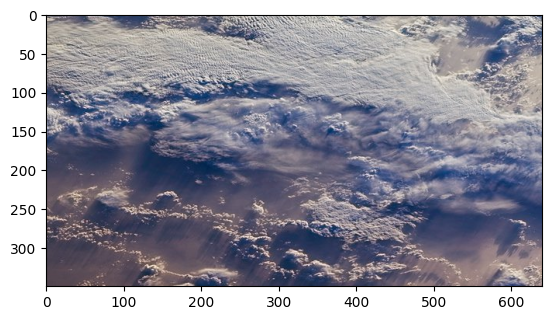

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

img_p = "C:/Users/Hp/Desktop/cloud_sat.jpg"
img_tst = load_img(img_p)
plt.imshow(img_tst)

In [ ]:
#Prediction
img_tst = load_img(img_p, target_size=(64,64))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

result = model.predict(img_array)
a = np.argmax(result)
if a==0:
    print("Cloud")
elif a==1:
    print("Desert")
elif a==2:
    print("Green Area")
else:
    print("Water")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cloud


In [ ]:
model.save("C:/Users/Hp/Desktop/TNI Project/model_002_final.h5")

In [ ]:
##############################################################################################################################################
##############################################################################################################################################

# Part III : Image Semantic Segmentation Classification



In [ ]:
##############################################################################################################################################
##############################################################################################################################################

In [ ]:
#!pip install patchify

In [ ]:
#!pip install scikit-learn

In [ ]:
import os
import cv2
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [ ]:
minmaxscaler = MinMaxScaler()

# 1: Import Data

In [ ]:
#dataset_root_folder = '/content/drive/MyDrive/ColabNotebooks/' si on utilise collab

In [ ]:
# Define the path to your dataset directory
dataset_root_folder = 'C:/Users/Hp/Downloads/archive/Semantic_segmentation_dataset/'

# List all files and directories in the dataset directory
all_entries = os.listdir(dataset_root_folder)

# Filter to keep only directories
dataset_name = [entry for entry in all_entries if os.path.isdir(os.path.join(dataset_root_folder, entry))]

# Print the list of subdirectories
print(dataset_name)

['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5', 'Tile 6', 'Tile 7', 'Tile 8']


In [ ]:
image_patch_size = 256

In [ ]:
#Initialize datasets
image_dataset = []
mask_dataset = []

# Define the dataset root folder
dataset_root_folder = 'C:/Users/Hp/Downloads/archive/Semantic_segmentation_dataset'

# Initialize the MinMaxScaler
minmaxscaler = MinMaxScaler()

# Define image patch size
image_patch_size = 256  # Example patch size, modify as needed

# Iterate over image types and process images
for image_type in ['images', 'masks']:
    image_extension = 'jpg' if image_type == 'images' else 'png'

    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image_path = os.path.join(dataset_root_folder, f'Tile {tile_id}', image_type, f'image_part_00{image_id}.{image_extension}')
            image = cv2.imread(image_path, 1)

            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size

                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)

                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

print("Total images patched:", len(image_dataset))
print("Total masks patched:", len(mask_dataset))


Total images patched: 945
Total masks patched: 945


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


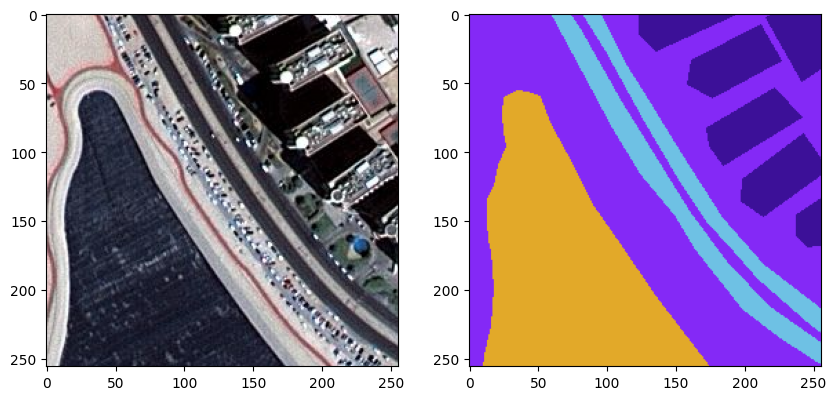

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
#Specifier les couleur de chaque classe
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
print(np.unique(labels)) #Nombre de categories
total_classes = len(np.unique(labels))
print("total_classes = " ,total_classes)

[0 1 2 3 4 5]
total_classes =  6


In [ ]:
#!pip install tensorflow


In [ ]:
#pip install --upgrade pip

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical


In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)


In [ ]:
master_trianing_dataset = image_dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# 2: Semantic Segmentation Deep Learning

In [ ]:
#!pip install -U segmentation-models

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
from keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten

In [ ]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value


In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
import keras
from IPython.display import clear_output
%matplotlib inline

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=8,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.5317 - jaccard_coef: 0.2715 - loss: 0.9998 - val_accuracy: 0.6861 - val_jaccard_coef: 0.3507 - val_loss: 0.9728
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7085 - jaccard_coef: 0.4264 - loss: 0.9689 - val_accuracy: 0.6977 - val_jaccard_coef: 0.4165 - val_loss: 0.9700
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7248 - jaccard_coef: 0.4712 - loss: 0.9619 - val_accuracy: 0.6859 - val_jaccard_coef: 0.4268 - val_loss: 0.9773
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.7424 - jaccard_coef: 0.4993 - loss: 0.9561 - val_accuracy: 0.7469 - val_jaccard_coef: 0.5024 - val_loss: 0.9570
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7714 - jaccard_coef: 0.5453 - loss: 0.9484 - val_accuracy: 0.7560 - val_jaccard_coef: 0.5385 - val_loss: 0.9538
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7870 - jaccard_coef: 0.5758 - loss: 0.

In [ ]:
history_a = model_history

In [ ]:
history_a.history

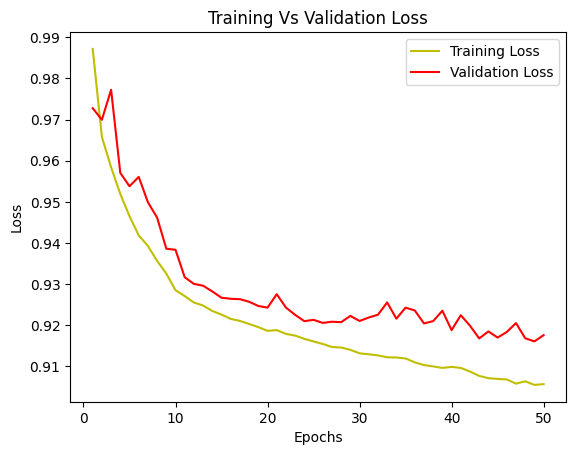

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

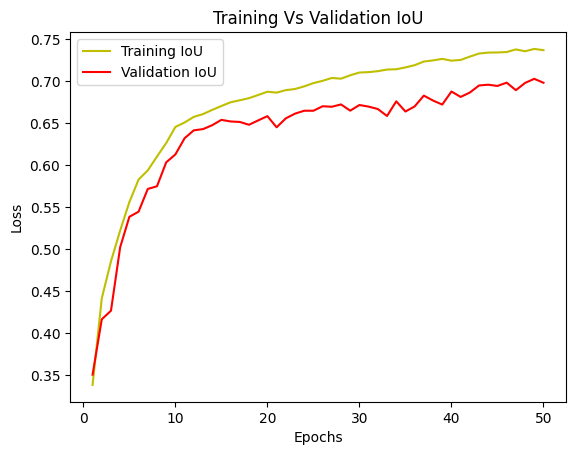

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 101}

In [ ]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [ ]:
len(y_pred)

142

In [ ]:
y_pred

array([[[[6.16201852e-03, 4.92267877e-01, 1.27357259e-01,
          2.79492706e-01, 8.34858194e-02, 1.12343356e-02],
         [1.62943068e-03, 5.62401056e-01, 8.67716670e-02,
          3.02239269e-01, 4.45275232e-02, 2.43109278e-03],
         [1.49792107e-03, 4.90766674e-01, 7.32190609e-02,
          3.87643844e-01, 4.45965528e-02, 2.27590837e-03],
         ...,
         [4.56566596e-03, 5.05365014e-01, 7.66277015e-02,
          3.10278177e-01, 9.93985012e-02, 3.76503519e-03],
         [7.59941014e-03, 4.73461539e-01, 8.00998881e-02,
          2.86065757e-01, 1.47763833e-01, 5.00957156e-03],
         [2.72494778e-02, 4.01391208e-01, 1.09917298e-01,
          2.67006516e-01, 1.77487627e-01, 1.69479512e-02]],

        [[1.40806788e-03, 5.39733827e-01, 8.37404206e-02,
          3.21180880e-01, 5.20151444e-02, 1.92158611e-03],
         [1.31808876e-04, 6.26167178e-01, 5.38420752e-02,
          2.92277277e-01, 2.72206739e-02, 3.60926497e-04],
         [1.70071755e-04, 5.22632539e-01, 5.4911

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

142

In [ ]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [ ]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)
prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


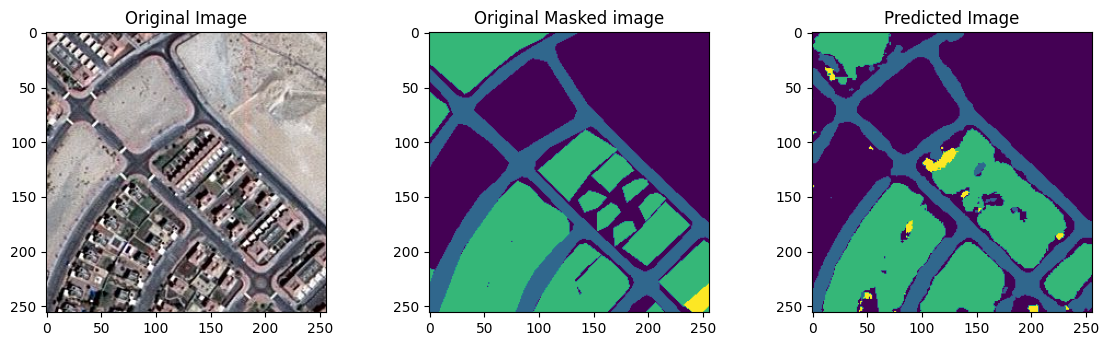

In [ ]:
#Comparing results with input masks

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("C:/Users/Hp/Desktop/TNI Project/model_001.h5")

In [ ]:
from keras.models import load_model

In [ ]:
saved_model = load_model('C:/Users/Hp/Desktop/TNI Project/model_001.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
saved_model.compile
saved_model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'cla

## Predict using image from Google Map

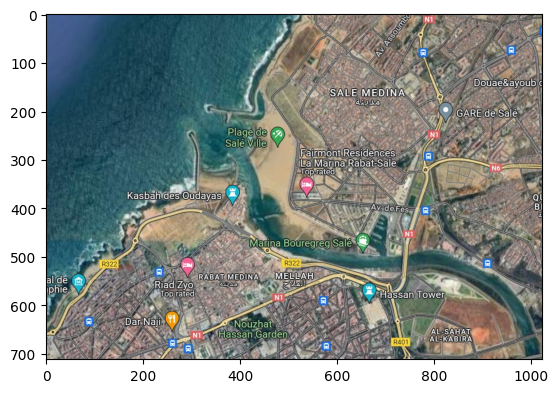

In [ ]:
img_path='C:/Users/Hp/Desktop/cap.jpg'
plt.imshow(Image.open(img_path))

In [ ]:
#utiliser le model pour la prédiction
image = Image.open(img_path)
image_res = image.resize((256,256))

image = np.array(image_res)
image = np.expand_dims(image, 0)

prediction = saved_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


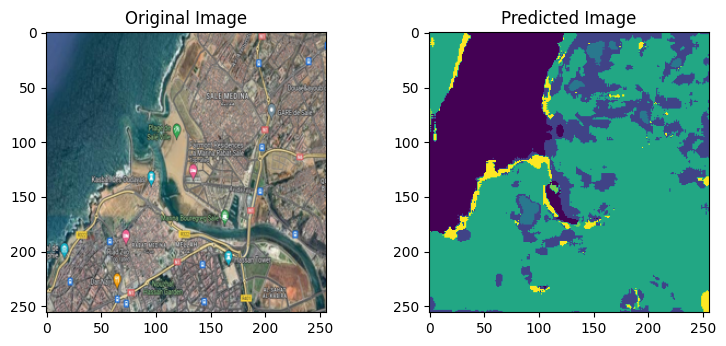

In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(image_res)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [ ]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)
prediction = saved_model.predict(test_image_input)
#prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

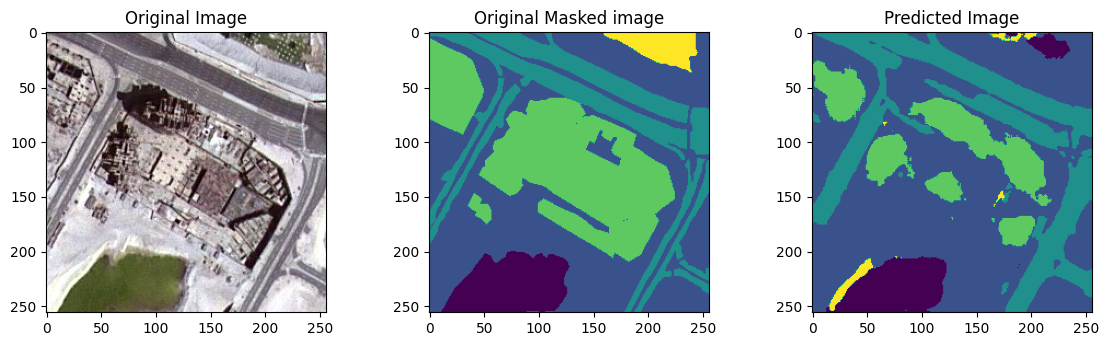

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)